In [1]:
import pandas as pd
import numpy as np
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.control_flow import scan
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import display, Math
from functions import plot_z
import warnings
warnings.simplefilter('ignore')

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

/Users/satoshan/.pyenv/versions/miniforge3-4.10.3-10/envs/forpymc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Real data
### Period 
1983-2018
### Output gap
Beveridge-Nelson Filter (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

---

In [2]:

data_cpi = pd.read_csv("data/CPIAUCSL.csv")
data_cpi['month'] = pd.to_datetime(data_cpi['DATE']).dt.month
data_cpi = data_cpi[data_cpi['month'] == 1]
data_cpi['year'] = pd.to_datetime(data_cpi['DATE']).dt.year
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi[['year', 'pi']]

data_gap = pd.read_csv("data/BN_filter_GDPC1_annual.csv")
data_gap['year'] = pd.to_datetime(data_gap['date']).dt.year
data_gap['Y'] = data_gap["cycle"]
data_gap = data_gap[["year", "Y"]]

data_Epi = pd.read_csv("data/inflation_expectations_monthly.csv")
data_Epi['month'] = pd.to_datetime(data_Epi['DateTime']).dt.month
data_Epi = data_Epi[data_Epi['month'] == 1]
data_Epi['year'] = pd.to_datetime(data_Epi['DateTime']).dt.year
data_Epi['Epi'] = data_Epi['expected_inflation']
data_Epi = data_Epi[['year', 'Epi']]

data = pd.merge(data_gap, data_Epi, on='year', how='inner')
data = pd.merge(data, data_cpi, on='year', how='inner')
data = data[data['year'] < 2019]
data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data = data[data['year'] > 1982]
year = data["year"].tolist()

# for MCMC
pi = jnp.array(data['pi'])
pi_prev = jnp.array(data['pi_prev'])
pi_expect = jnp.array(data['Epi'])
Y = jnp.array(data['Y'])
Y_prev = jnp.array(data['Y_prev'])

####  Model

"COMPETITION AND THE PHILLIPS CURVE"

Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$

## Estimation

The observed variable $\pi_t$ is the inflation rate, $\text{E}\pi_t$ is the expected inflation rate, and $\text{gap}_t$ is the output gap


In [3]:
warmup= 10000
samples=15000
chains = 4
rng_key = jax.random.PRNGKey(0)

In [4]:
from models import model_0_0
from models import model_0_1
# RUN MCMC
kernel = NUTS(model_0_0)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y)
idata_0_0 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_0_kappa = posterior_samples["kappa"].mean()
model_0_0_beta = posterior_samples["beta"].mean()
model_0_0_text = r"""---
Model 0.0. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t  + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
"""
display(Markdown(model_0_0_text))
result_0_0=rf"""
Result $$\pi_{{t}} = {model_0_0_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_0_0_kappa:.4f}\, Y_t + \epsilon_t$$
"""
display(Markdown(result_0_0))

sample: 100%|██████████| 25000/25000 [00:03<00:00, 7849.98it/s, 3 steps of size 5.97e-01. acc. prob=0.84] 


---
Model 0.0. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t  + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$



Result $$\pi_{t} = 0.9556\, E_t[\pi_{t+1}] + 0.0437\, Y_t + \epsilon_t$$


In [5]:
# RUN MCMC
kernel = NUTS(model_0_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y)
idata_0_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_1_kappa  = posterior_samples["kappa"].mean()
model_0_1_beta = posterior_samples["beta"].mean()
model_0_1_alpha = posterior_samples["alpha"].mean()


model_0_1_text = r"""---
Model 0.1. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
"""
display(Markdown(model_0_1_text))
result_0_1=rf"""
Result $$\pi_{{t}} = {model_0_1_alpha:.4f}\, \pi_{{t-1}} + {model_0_1_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_0_1_kappa:.4f}\, Y_t + \epsilon_t$$
"""
display(Markdown(result_0_1))

sample: 100%|██████████| 25000/25000 [00:03<00:00, 7205.03it/s, 15 steps of size 2.57e-01. acc. prob=0.93]


---
Model 0.1. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$



Result $$\pi_{t} = -0.0133\, \pi_{t-1} + 0.9687\, E_t[\pi_{t+1}] + 0.0452\, Y_t + \epsilon_t$$


In [6]:
from models import model_1
# RUN MCMC
kernel = NUTS(model_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_1 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_1 = z_mean_1 - 1.96 * z_std     
z_upper_1 = z_mean_1 + 1.96 * z_std  

model_1_kappa = posterior_samples["kappa"].mean()
model_1_theta = posterior_samples["theta"].mean()
model_1_beta  = posterior_samples["beta"].mean()
model_1_rho  = posterior_samples["rho"].mean()

model_1_text = r"""---
Model 1. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_1_text))
result_1=rf"""
Result $$\pi_{{t}} = {model_1_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_1_kappa:.4f}\, Y_t - {model_1_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_1_rho:.4f}  z_{{t-1}} + \eta_t$$
"""
display(Markdown(result_1))

sample: 100%|██████████| 25000/25000 [00:06<00:00, 3787.85it/s, 31 steps of size 8.15e-02. acc. prob=0.75] 


---
Model 1. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9565\, E_t[\pi_{t+1}] + 0.0438\, Y_t - 0.5668\, z_t + \epsilon_t$$
$$z_{t} = 0.3901  z_{t-1} + \eta_t$$


In [7]:
from models import model_2
# RUN MCMC
kernel = NUTS(model_2)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_2 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_2 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_2 = z_mean_2 - 1.96 * z_std     
z_upper_2 = z_mean_2 + 1.96 * z_std    

model_2_kappa = posterior_samples["kappa"].mean()
model_2_alpha = posterior_samples["alpha"].mean()
model_2_theta = posterior_samples["theta"].mean()
model_2_beta = posterior_samples["beta"].mean()
model_2_rho = posterior_samples["rho"].mean()

model_2_text = r"""---
Model 2. 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_2_text))
result_2=rf"""
Result $$\pi_{{t}} = {model_2_alpha:.4f}\, \pi_{{t-1}} + {model_2_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_2_kappa:.4f}\, Y_t - {model_2_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_2_rho:.4f}  z_{{t-1}} + \eta_t$$
"""
display(Markdown(result_2))

sample: 100%|██████████| 25000/25000 [00:06<00:00, 3660.12it/s, 31 steps of size 9.12e-02. acc. prob=0.78] 


---
Model 2. 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0654\, \pi_{t-1} + 0.8904\, E_t[\pi_{t+1}] + 0.0443\, Y_t - 0.6115\, z_t + \epsilon_t$$
$$z_{t} = 0.4277  z_{t-1} + \eta_t$$


In [8]:
from models import model_3
# RUN MCMC
kernel = NUTS(model_3)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_3 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_3 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_3 = z_mean_3 - 1.96 * z_std     
z_upper_3 = z_mean_3 + 1.96 * z_std  

model_3_kappa = posterior_samples["kappa"].mean()
model_3_theta = posterior_samples["theta"].mean()
model_3_beta = posterior_samples["beta"].mean()
model_3_rho_1 = posterior_samples["rho1"].mean()
model_3_rho_2 = posterior_samples["rho2"].mean()

model_3_text = r"""---
Model 3. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_3_text))
result_3=rf"""
Result $$\pi_{{t}} = {model_3_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_3_kappa:.4f}\, Y_t - {model_3_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_3_rho_1:.4f}  z_{{t-1}} - {model_3_rho_2:.4f}  Y_{{t-1}} + \eta_t$$
"""
display(Markdown(result_3))

sample: 100%|██████████| 25000/25000 [00:06<00:00, 3705.83it/s, 2 steps of size 7.58e-02. acc. prob=0.63]  


---
Model 3. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9640\, E_t[\pi_{t+1}] + 0.0386\, Y_t - 0.2351\, z_t + \epsilon_t$$
$$z_{t} = -0.0557  z_{t-1} - 0.3973  Y_{t-1} + \eta_t$$


In [9]:
from models import model_4
# RUN MCMC
kernel = NUTS(model_4)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_4 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_4 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_4 = z_mean_4 - 1.96 * z_std     
z_upper_4 = z_mean_4 + 1.96 * z_std  

model_4_alpha = posterior_samples["alpha"].mean()
model_4_kappa = posterior_samples["kappa"].mean()
model_4_theta = posterior_samples["theta"].mean()
model_4_beta = posterior_samples["beta"].mean()
model_4_rho_1 = posterior_samples["rho1"].mean()
model_4_rho_2 = posterior_samples["rho2"].mean()
model_4_text = r"""---
Model 4. 
$$
\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_4_text))
result_4=rf"""
Result $$\pi_{{t}} = {model_4_alpha:.4f}\, \pi_{{t-1}} + {model_4_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_4_kappa:.4f}\, Y_t - {model_4_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_4_rho_1:.4f}  z_{{t-1}} - {model_4_rho_2:.4f}  Y_{{t-1}} + \eta_t$$
"""
display(Markdown(result_4))

sample: 100%|██████████| 25000/25000 [00:07<00:00, 3285.67it/s, 63 steps of size 4.68e-02. acc. prob=0.70] 


---
Model 4. 
$$
\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0339\, \pi_{t-1} + 0.9289\, E_t[\pi_{t+1}] + 0.0429\, Y_t - 0.2706\, z_t + \epsilon_t$$
$$z_{t} = -0.1547  z_{t-1} - 0.4675  Y_{t-1} + \eta_t$$


In [ ]:
from models import model_5
# RUN MCMC
kernel = NUTS(model_5)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_5 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_5 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_5 = z_mean_5 - 1.96 * z_std     
z_upper_5 = z_mean_5 + 1.96 * z_std  

model_5_kappa = posterior_samples["kappa"].mean()
model_5_beta = posterior_samples["beta"].mean()
model_5_theta = posterior_samples["theta"].mean()
model_5_rho_1 = posterior_samples["rho1"].mean()
model_5_rho_2 = posterior_samples["rho2"].mean()
model_5_rho_3 = posterior_samples["rho3"].mean()

model_5_text = r"""---
Model 5. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \pi_{{t-1}} + \rho_3 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_5_text))
result_5=rf"""
Result $$\pi_{{t}} = {model_5_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_5_kappa:.4f}\, Y_t - {model_5_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_5_rho_1:.4f}  z_{{t-1}} + {model_5_rho_2:.4f}  \pi_{{t-1}} - {model_5_rho_3:.4f}  Y_{{t-1}} + \eta_t$$
"""
display(Markdown(result_5))

sample: 100%|██████████| 25000/25000 [00:07<00:00, 3191.54it/s, 31 steps of size 5.99e-02. acc. prob=0.70] 


---
Model 5. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \pi_{{t-1}} + \rho_3 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$


"
Result $$\pi_{t} = 0.9588\, E_t[\pi_{t+1}] + 0.0422\, Y_t - 0.1341\, z_t + \epsilon_t$$
$$z_{t} = -0.0707  z_{t-1} + 0.0076  \pi_{t-1} - 0.4455  Y_{t-1} + \eta_t$$


In [11]:
from models import model_6
# RUN MCMC
kernel = NUTS(model_6)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_6 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_6 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_6 = z_mean_6 - 1.96 * z_std     
z_upper_6 = z_mean_6 + 1.96 * z_std  

model_6_alpha = posterior_samples["alpha"].mean()
model_6_kappa = posterior_samples["kappa"].mean()
model_6_beta = posterior_samples["beta"].mean()
model_6_theta = posterior_samples["theta"].mean()
model_6_rho_1 = posterior_samples["rho1"].mean()
model_6_rho_2 = posterior_samples["rho2"].mean()
model_6_rho_3 = posterior_samples["rho3"].mean()
model_6_text = r"""---
Model 6. 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \pi_{{t-1}} + \rho_3 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_6_text))
result_6=rf"""
Result $$\pi_{{t}} = {model_6_alpha:.4f}\, \pi_{{t-1}} + {model_6_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_6_kappa:.4f}\, Y_t - {model_6_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_6_rho_1:.4f}  z_{{t-1}} + {model_6_rho_2:.4f}  \pi_{{t-1}} - {model_6_rho_3:.4f}  Y_{{t-1}} + \eta_t$$
"""
display(Markdown(result_6))

sample: 100%|██████████| 25000/25000 [00:09<00:00, 2580.85it/s, 511 steps of size 3.80e-02. acc. prob=0.57]


---
Model 6. 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \pi_{{t-1}} + \rho_3 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0565\, \pi_{t-1} + 0.9238\, E_t[\pi_{t+1}] + 0.0440\, Y_t - 0.1934\, z_t + \epsilon_t$$
$$z_{t} = -0.0658  z_{t-1} + 0.0947  \pi_{t-1} - 0.5126  Y_{t-1} + \eta_t$$


In [12]:
from models import model_7
# RUN MCMC
kernel = NUTS(model_7)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_7 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_7 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_7 = z_mean_7 - 1.96 * z_std     
z_upper_7 = z_mean_7 + 1.96 * z_std  

model_7_kappa = posterior_samples["kappa"].mean()
model_7_theta = posterior_samples["theta"].mean()
model_7_beta  = posterior_samples["beta"].mean()
model_7_rho_1 = posterior_samples["rho1"].mean()
model_7_rho_2 = posterior_samples["rho2"].mean()
model_7_text = r"""---
Model 7. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_7_text))
result_7=rf"""
Result $$\pi_{{t}} = {model_7_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_7_kappa:.4f}\, Y_t - {model_7_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_7_rho_1:.4f}  z_{{t-1}} - {model_7_rho_2:.4f}  Y_{{t}} + \eta_t$$
"""
display(Markdown(result_7))

sample: 100%|██████████| 25000/25000 [00:07<00:00, 3344.12it/s, 23 steps of size 7.32e-02. acc. prob=0.68] 


---
Model 7. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9587\, E_t[\pi_{t+1}] + 0.0410\, Y_t - 0.2135\, z_t + \epsilon_t$$
$$z_{t} = -0.0809  z_{t-1} - 0.3588  Y_{t} + \eta_t$$


In [13]:
from models import model_8
# RUN MCMC
kernel = NUTS(model_8)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_8 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_8 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_8 = z_mean_8 - 1.96 * z_std     
z_upper_8 = z_mean_8 + 1.96 * z_std  

model_8_kappa = posterior_samples["kappa"].mean()
model_8_theta = posterior_samples["theta"].mean()
model_8_alpha = posterior_samples["alpha"].mean()
model_8_beta  = posterior_samples["beta"].mean()
model_8_rho_1 = posterior_samples["rho1"].mean()
model_8_rho_2 = posterior_samples["rho2"].mean()
model_8_text = r"""---
Model 8. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} - rho_2 \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_8_text))
result_8=rf"""
Result $$\pi_{{t}} = {model_8_alpha:.4f}\, \pi_{{t-1}} + {model_8_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_8_kappa:.4f}\, Y_t - {model_8_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_8_rho_1:.4f}\, z_{{t-1}} - {model_8_rho_2:.4f}  Y_{{t}} + \eta_t$$
"""
display(Markdown(result_8))

sample: 100%|██████████| 25000/25000 [00:08<00:00, 3092.70it/s, 63 steps of size 8.88e-02. acc. prob=0.42] 


---
Model 8. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} - rho_2 \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0365\, \pi_{t-1} + 0.9242\, E_t[\pi_{t+1}] + 0.0442\, Y_t - 0.2313\, z_t + \epsilon_t$$
$$z_{t} = -0.1150\, z_{t-1} - 0.4067  Y_{t} + \eta_t$$


In [14]:
from models import model_9
# RUN MCMC
kernel = NUTS(model_9)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_9 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_9 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_9 = z_mean_9 - 1.96 * z_std     
z_upper_9 = z_mean_9 + 1.96 * z_std  

model_9_kappa = posterior_samples["kappa"].mean()
model_9_theta = posterior_samples["theta"].mean()
model_9_beta  = posterior_samples["beta"].mean()
model_9_rho   = posterior_samples["rho"].mean()

model_9_text = r"""---
Model 9. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_9_text))
result_9=rf"""
Result $$\pi_{{t}} = {model_9_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_9_kappa:.4f}\, Y_t - {model_9_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = - {model_9_rho:.4f}  Y_{{t}} + \eta_t$$
"""
display(Markdown(result_9))

sample: 100%|██████████| 25000/25000 [00:05<00:00, 4211.32it/s, 23 steps of size 9.35e-02. acc. prob=0.69] 


---
Model 9. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9614\, E_t[\pi_{t+1}] + 0.0399\, Y_t - 0.2645\, z_t + \epsilon_t$$
$$z_{t} = - 0.2896  Y_{t} + \eta_t$$


In [15]:
from models import model_10
# RUN MCMC
kernel = NUTS(model_10)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_10 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_10 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_10 = z_mean_10 - 1.96 * z_std     
z_upper_10 = z_mean_10 + 1.96 * z_std  

model_10_kappa = posterior_samples["kappa"].mean()
model_10_theta = posterior_samples["theta"].mean()
model_10_alpha = posterior_samples["alpha"].mean()
model_10_beta  = posterior_samples["beta"].mean()
model_10_rho   = posterior_samples["rho"].mean()
model_10_text = r"""---
Model 10. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta  \hat{z}_{t} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t =  \rho \hat{Y}_{t} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_10_text))
result_10=rf"""
Result $$\pi_{{t}} = {model_10_alpha:.4f}\, \pi_{{t-1}} + {model_10_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_10_kappa:.4f}\, Y_t - {model_10_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = - {model_10_rho:.4f}  Y_{{t}} + \eta_t$$
"""
display(Markdown(result_10))

sample: 100%|██████████| 25000/25000 [00:07<00:00, 3435.09it/s, 23 steps of size 8.34e-02. acc. prob=0.65] 


---
Model 10. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta  \hat{z}_{t} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t =  \rho \hat{Y}_{t} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0232\, \pi_{t-1} + 0.9311\, E_t[\pi_{t+1}] + 0.0373\, Y_t - 0.4052\, z_t + \epsilon_t$$
$$z_{t} = - 0.2103  Y_{t} + \eta_t$$


## Results

## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
$$
\text{lppd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$

'WAIC'

'Leave One Out cross validation'

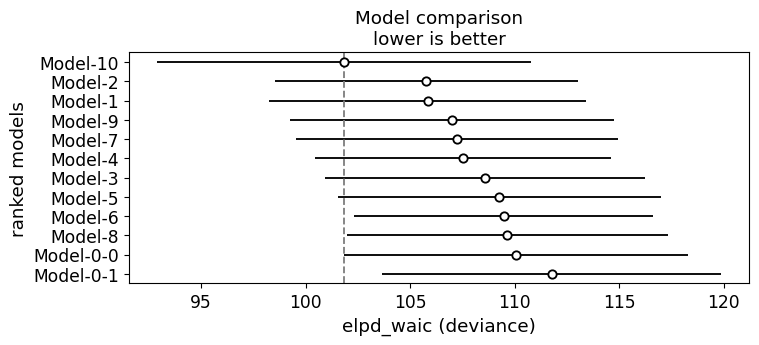

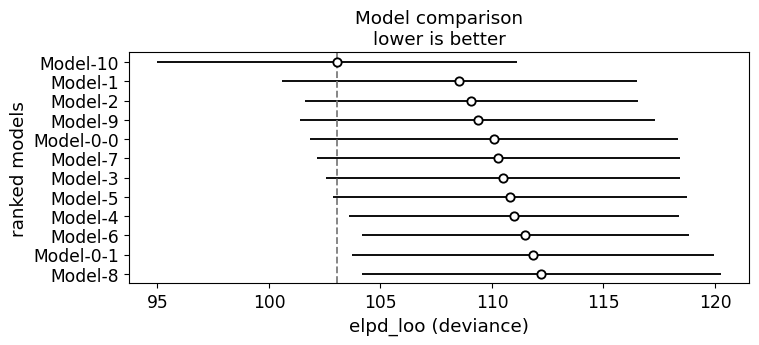

In [16]:
display("WAIC")
dict_idata = {'Model-0-0':idata_0_0,'Model-0-1':idata_0_1,'Model-1':idata_1, 'Model-2':idata_2,'Model-3':idata_3, 'Model-4':idata_4,
              'Model-5':idata_5,'Model-6':idata_6, 'Model-7':idata_7,'Model-8':idata_8, 'Model-9':idata_9, 'Model-10':idata_10}
df_waic = az.compare(dict_idata, ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(8, 3));

display("Leave One Out cross validation")
df_loo = az.compare(dict_idata, ic='loo', scale='deviance')
az.plot_compare(df_loo, figsize=(8, 3));

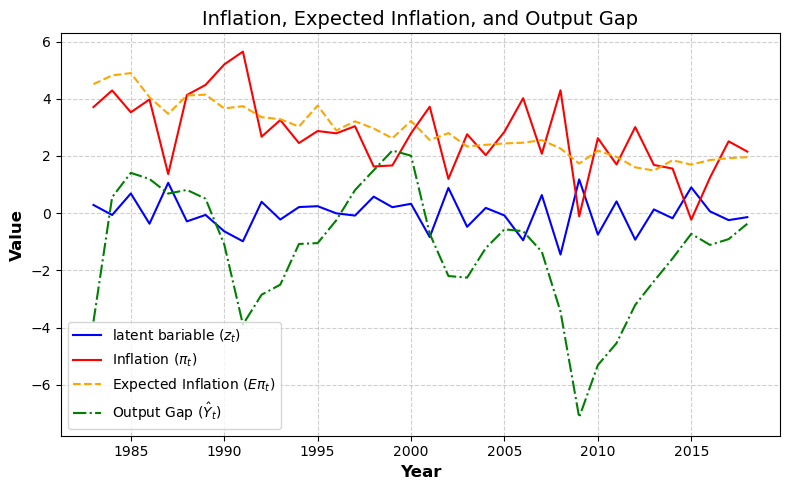

In [17]:
# data
plt.figure(figsize=(8, 5))
plt.plot(year, z_mean_1, label=r'latent bariable $(z_{t})$', linestyle='-', color='blue')       
plt.plot(year, data["pi"], label=r'Inflation $(\pi_{t})$', linestyle='-', color='red')       
plt.plot(year, data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')    
plt.plot(year, data["Y"], label='Output Gap $(\hat{Y}_{t})$', linestyle='-.', color='green') 
plt.xlabel('Year', fontsize=12, weight='bold')
plt.ylabel('Value', fontsize=12, weight='bold')
plt.title('Inflation, Expected Inflation, and Output Gap', fontsize=14)
plt.legend(fontsize=10, frameon=True, loc='lower left', fancybox=True)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

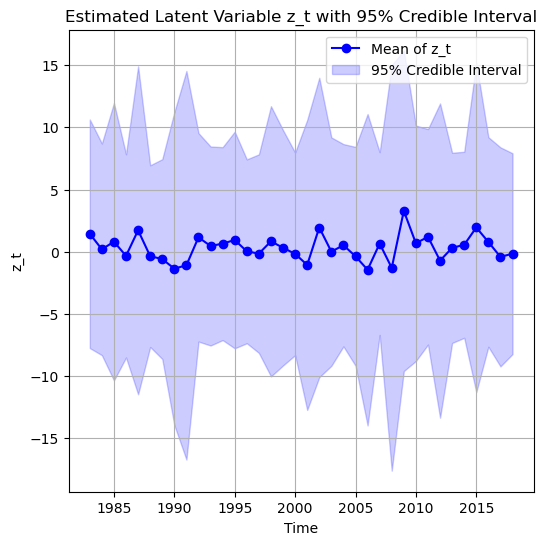

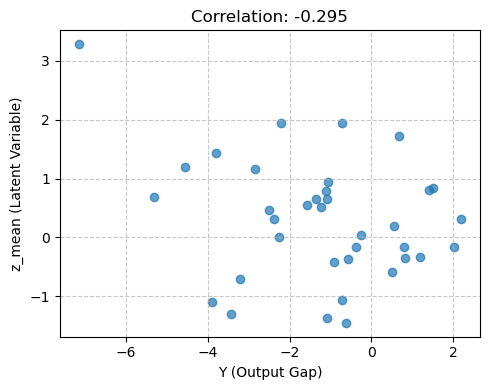

In [26]:
plot_z(year, z_mean_9,z_lower_9, z_upper_9, Y)

In [19]:
print("Normal NK model")
display(Markdown(model_0_0_text))
display(Markdown(result_0_0))
display(Markdown(model_0_1_text))
display(Markdown(result_0_1))

Normal NK model


---
Model 0.0. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t  + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$



Result $$\pi_{t} = 0.9556\, E_t[\pi_{t+1}] + 0.0437\, Y_t + \epsilon_t$$


---
Model 0.1. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$



Result $$\pi_{t} = -0.0133\, \pi_{t-1} + 0.9687\, E_t[\pi_{t+1}] + 0.0452\, Y_t + \epsilon_t$$


In [20]:
print("AR1 latent variable")
display(Markdown(model_1_text))
display(Markdown(result_1))
display(Markdown(model_2_text))
display(Markdown(result_2))

AR1 latent variable


---
Model 1. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9565\, E_t[\pi_{t+1}] + 0.0438\, Y_t - 0.5668\, z_t + \epsilon_t$$
$$z_{t} = 0.3901  z_{t-1} + \eta_t$$


---
Model 2. 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0654\, \pi_{t-1} + 0.8904\, E_t[\pi_{t+1}] + 0.0443\, Y_t - 0.6115\, z_t + \epsilon_t$$
$$z_{t} = 0.4277  z_{t-1} + \eta_t$$


In [21]:
print("previous Y affect z")
display(Markdown(model_3_text))
display(Markdown(result_3))
display(Markdown(model_4_text))
display(Markdown(result_4))

previous Y affect z


---
Model 3. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9640\, E_t[\pi_{t+1}] + 0.0386\, Y_t - 0.2351\, z_t + \epsilon_t$$
$$z_{t} = -0.0557  z_{t-1} - 0.3973  Y_{t-1} + \eta_t$$


---
Model 4. 
$$
\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0339\, \pi_{t-1} + 0.9289\, E_t[\pi_{t+1}] + 0.0429\, Y_t - 0.2706\, z_t + \epsilon_t$$
$$z_{t} = -0.1547  z_{t-1} - 0.4675  Y_{t-1} + \eta_t$$


In [22]:
print("previous Y and inflation affect z")
display(Markdown(model_5_text))
display(Markdown(result_5))
display(Markdown(model_6_text))
display(Markdown(result_6))

previous Y and inflation affect z


---
Model 5. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \pi_{{t-1}} + \rho_3 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$


"
Result $$\pi_{t} = 0.9588\, E_t[\pi_{t+1}] + 0.0422\, Y_t - 0.1341\, z_t + \epsilon_t$$
$$z_{t} = -0.0707  z_{t-1} + 0.0076  \pi_{t-1} - 0.4455  Y_{t-1} + \eta_t$$


---
Model 6. 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \pi_{{t-1}} + \rho_3 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0565\, \pi_{t-1} + 0.9238\, E_t[\pi_{t+1}] + 0.0440\, Y_t - 0.1934\, z_t + \epsilon_t$$
$$z_{t} = -0.0658  z_{t-1} + 0.0947  \pi_{t-1} - 0.5126  Y_{t-1} + \eta_t$$


In [23]:
print("Y and previous z affect z")
display(Markdown(model_7_text))
display(Markdown(result_7))
display(Markdown(model_8_text))
display(Markdown(result_8))

Y and previous z affect z


---
Model 7. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9587\, E_t[\pi_{t+1}] + 0.0410\, Y_t - 0.2135\, z_t + \epsilon_t$$
$$z_{t} = -0.0809  z_{t-1} - 0.3588  Y_{t} + \eta_t$$


---
Model 8. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} - rho_2 \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0365\, \pi_{t-1} + 0.9242\, E_t[\pi_{t+1}] + 0.0442\, Y_t - 0.2313\, z_t + \epsilon_t$$
$$z_{t} = -0.1150\, z_{t-1} - 0.4067  Y_{t} + \eta_t$$


In [24]:
print("Y affect z")
display(Markdown(model_9_text))
display(Markdown(result_9))
display(Markdown(model_10_text))
display(Markdown(result_10))

Y affect z


---
Model 9. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9614\, E_t[\pi_{t+1}] + 0.0399\, Y_t - 0.2645\, z_t + \epsilon_t$$
$$z_{t} = - 0.2896  Y_{t} + \eta_t$$


---
Model 10. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta  \hat{z}_{t} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t =  \rho \hat{Y}_{t} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0232\, \pi_{t-1} + 0.9311\, E_t[\pi_{t+1}] + 0.0373\, Y_t - 0.4052\, z_t + \epsilon_t$$
$$z_{t} = - 0.2103  Y_{t} + \eta_t$$
